# K-Nearest Neighbours - Class Exercise 1

## Introduction

This diabetes dataset comprises several medical variables including the number of pregnancies, plasma glucose concentration, diastolic blood pressure, triceps skin fold thickness, 2-hour serum insulin, body mass index (BMI), diabetes pedigree function, and age. These attributes provide insights into an individual's health status and are used to predict the outcome variable, which denotes whether a person has been diagnosed with diabetes (1) or not (0).

Our goal is to use K-nearest neighbours to classify people with diabetes based on their medical data.

## Metadata

| Variables            | Description                                               |
|----------------------|-----------------------------------------------------------|
| Pregnancies          | Number of times pregnant                                  |
| Glucose              | Plasma glucose concentration a 2 hours in an oral glucose tolerance test |
| Blood Pressure       | Diastolic blood pressure (mmHg)                           |
| Skin thickness       | Triceps skin fold thickness (mm)                          |
| Insulin              | 2-Hour serum insulin (mu U/ml)                            |
| BMI                  | Body mass index (weight in kg/(height in m)^2)            |
| Diabetes Pedigree Function | Diabetes pedigree function                          |
| Age                  | Age of person                                             |
| Outcome              | Class variable (0 = non-diabetic, 1 = diabetic)           |



## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## Import data

In [2]:
df = pd.read_csv('diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


## Check for missing values

In [3]:
missing_values = df.isnull().sum()
missing_values

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

We observe that there are no missing values in the dataset.

## Normalize data

K-nearest neighbours algorithm uses distance metrics to measure similarity between objects, and these distance metrics are sensitive to the scale of data. Hence, we will normalize the data to ensure that variables with larger numerical values do not dominate the distance calculations.

In [4]:
label = 'Outcome'
excluded_columns = [label]
features = [feature for feature in list(df) if feature not in excluded_columns]

In [5]:
X = df[features]
y = df[label]

In [6]:
# Create instance of min-max normalizer
normalizer = MinMaxScaler()

# Fit normalizer to the data
normalizer.fit(X)

# Normalize the data
X_norm = normalizer.transform(X)

## Train-test split

In [7]:
# Specify split parameters
random_seed = 9002
test_size = 0.2

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=test_size, random_state=random_seed)

In [8]:
print('Size of train set: ', len(X_train))
print('Size of test set: ', len(X_test))

Size of train set:  614
Size of test set:  154


## Fit kNN model

In [9]:
# Specify model parameters
k = 5
power = 2

# Build model
model = KNeighborsClassifier(n_neighbors=k, p=power)

# Fit model on training data
model.fit(X_train, y_train)

KNeighborsClassifier()

## Visualise kNN model

We will visualise the kNN model using a **decision boundary plot**. However, since the kNN model was built on multi-dimensional data, we need to select the best two discriminatory variables to use as the axes for the two-dimensional decision boundary plot.

First, we plot side-by-side boxplots for all attributes grouped by the target variable. This will help us determine the best two discriminatory variables to use for the decision boundary plot.

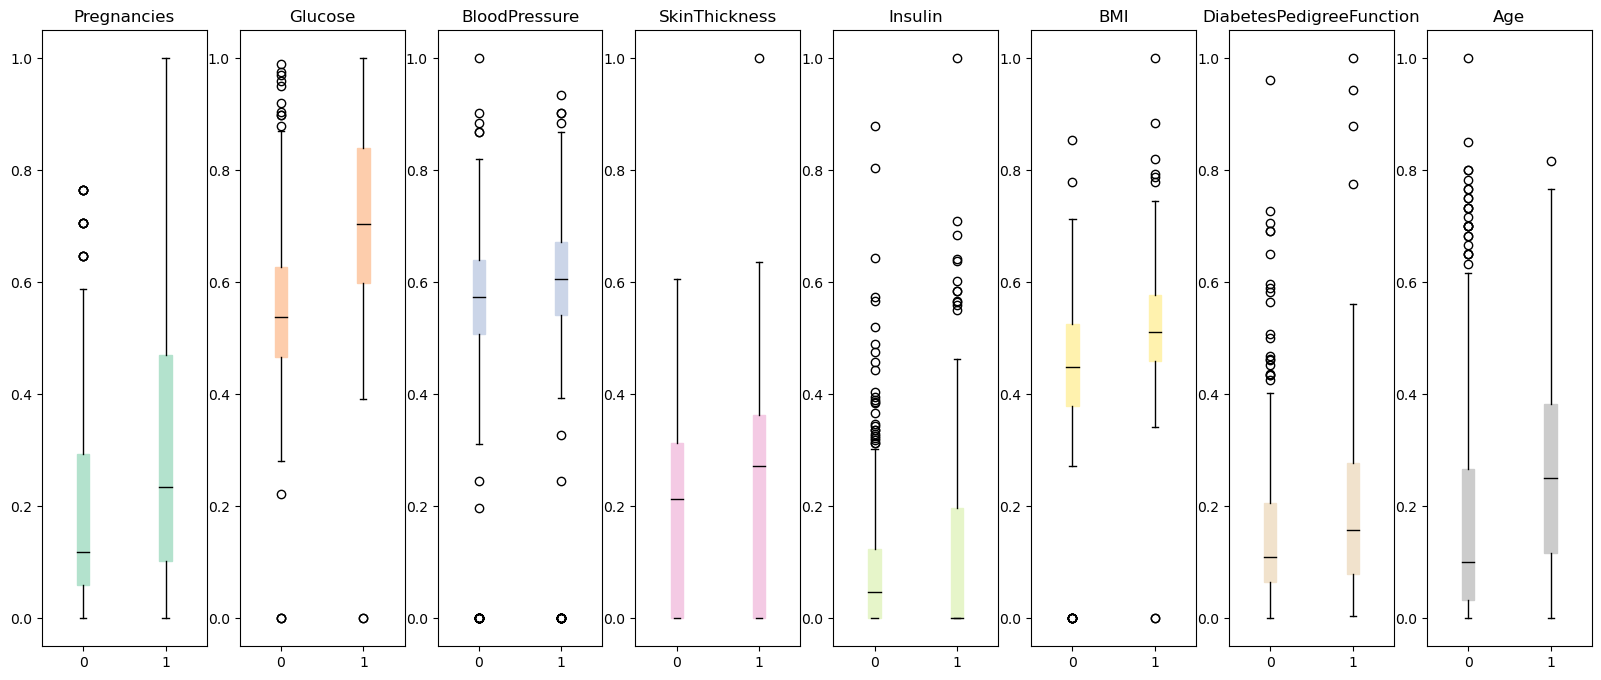

In [10]:
plt.figure(figsize=(20, 8))

num_features = X_norm.shape[1]
colors = [plt.cm.Pastel2(i/(num_features-1)) for i in range(num_features)]

for i in range(num_features):
    plt.subplot(1, num_features, i+1)
    plt.boxplot([X_norm[y==0, i], X_norm[y==1, i]], labels=['0', '1'], patch_artist=True, boxprops=dict(facecolor=colors[i], color=colors[i]), medianprops=dict(color="black"))
    plt.title(X.columns[i])

plt.show()

From the above boxplots, we observe that ```Glucose``` and ```BMI``` are the best two discriminatory variables, as they have the smallest overlap in boxes.

We will now generate the decision boundary plot using these two variables as the plot axes.

In [11]:
# Write a custom function to implement the decision boundary plot

def decision_boundary(variables, df, X_norm, y, model):

    # Get k value from model
    k = model.n_neighbors

    # Find column IDs for the given variable names
    col_ids = [df.columns.get_loc(var) for var in variables]
    
    # Create a mesh to plot the decision boundaries
    x_min, x_max = 0, 1
    y_min, y_max = 0, 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    
    # Prepare a template array with repeated mean values
    X_mean = np.mean(X_norm, axis=0)
    X_template = np.tile(X_mean, (xx.size, 1))
    
    # Overwrite the specified variables in X_template with the actual values from the meshgrid
    X_template[:, col_ids[0]] = xx.ravel()
    X_template[:, col_ids[1]] = yy.ravel()

    # Predict class for each mesh point and reshape to meshgrid shape
    Z = model.predict(X_template)
    Z = Z.reshape(xx.shape)

    # Plot the decision boundaries
    plt.contourf(xx, yy, Z, alpha=0.5)
    plt.scatter(X_norm[:, col_ids[0]], X_norm[:, col_ids[1]], c=y, edgecolors='k')
    plt.title(f'Decision Boundary for kNN classifier with k={k}')
    plt.xlabel(variables[0])
    plt.ylabel(variables[1])
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.show()

In [12]:
# Define the two variables to use as axes in decision boundary plot
variables = ['Glucose', 'BMI']

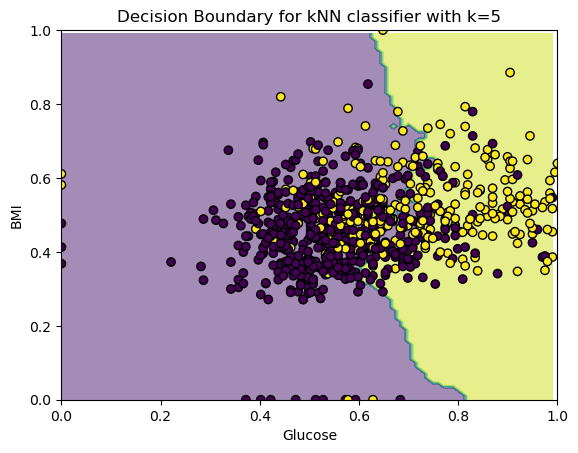

In [13]:
# Generate the decision boundary plot
decision_boundary(variables, df, X_norm, y, model)

## Evaluate model

In [14]:
# Predict test data
y_pred = model.predict(X_test)

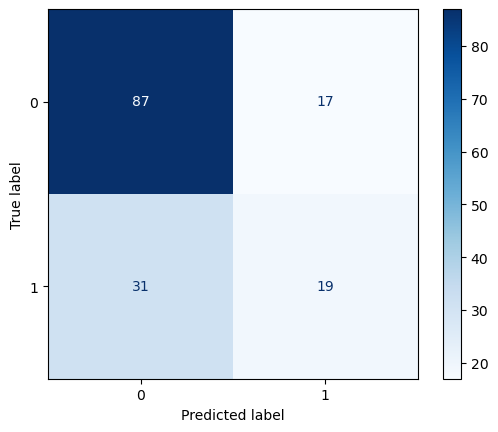

In [15]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [16]:
# Check test accuracy
accuracy_test = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy_test:.2f}")

Test accuracy: 0.69


## Model improvement

To improve the model, we will experiment with two hyperparameters:
* ```n_neighbors``` (i.e. ```k```, number of neighbours)
* ```p``` (i.e. ```power```, distance metric)

We will first define the hyperparameter grid for ```k``` and ```power```, which contains values for these two hyperparameters that we will be experimenting with. Then, we will use ```GridSearchCV``` to perform a grid search to obtain the optimal values of the two hyperparameters.

In [17]:
# Define hyperparameter grid
param_grid = {
    'n_neighbors': np.arange(1,51),   # [1 2 ... 49 50]
    'p': [1, 2]   # 1 = Manhattan distance, 2 = Euclidean distance
}

In [18]:
# Perform grid search with 10-fold cross-validation
model = KNeighborsClassifier()
cv = KFold(n_splits=10, shuffle=True, random_state=9002)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train);

In [19]:
# Display best params and best validation score
print("Best parameters:", grid_search.best_params_)
print(f"Best average cross-validation score: {grid_search.best_score_:.2f}")

Best parameters: {'n_neighbors': 29, 'p': 1}
Best average cross-validation score: 0.77


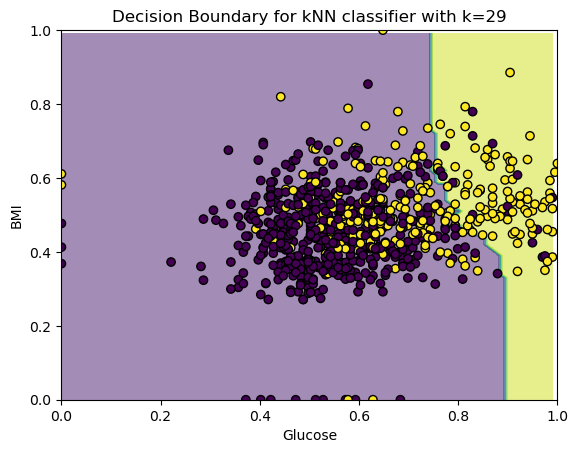

In [20]:
# Fit optimal model using best params found above
optimal_model = grid_search.best_estimator_

# Visualize the optimal kNN classifier
decision_boundary(variables, df, X_norm, y, optimal_model)

In [21]:
# Apply the optimal model on the test data
y_test_pred = optimal_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_accuracy:.2f}")

Test accuracy: 0.71


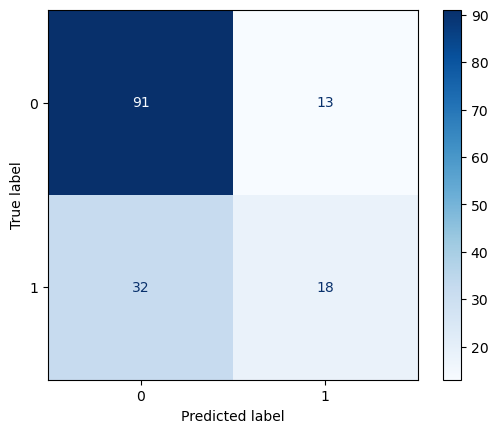

In [22]:
# Generate confusion matrix for optimal model
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()